# Assignment-3 Deep Learning AI2100

## Name-Gunjit Mittal     Roll No.-AI21BTECH11011

In [194]:
# Importing the required libraries
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

# Q1 Variants of Backprop for visualizing CNNs

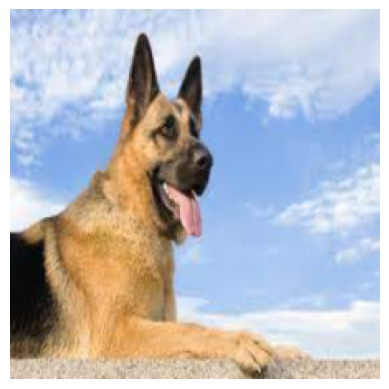

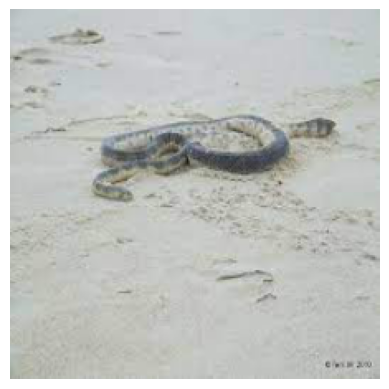

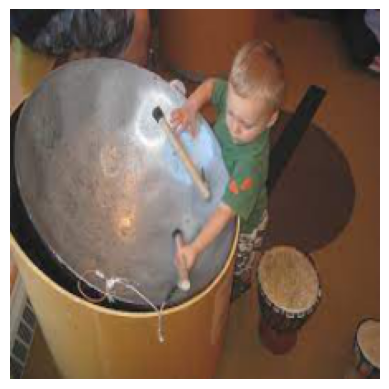

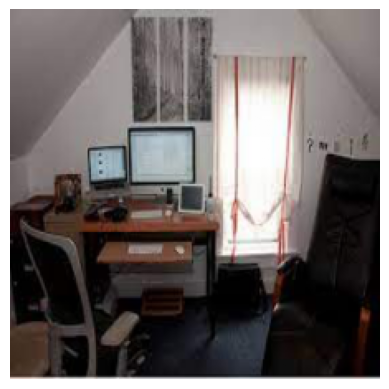

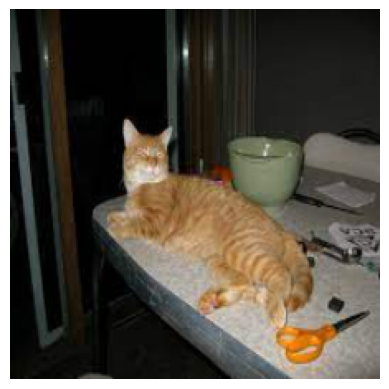

In [195]:
# Loading and resizing the image and loading the model
resnet50 = models.resnet50(weights='DEFAULT')
resnet50.eval()
images = []
for i in range(1, 6):
    image_path = f'i{i}.jpg'
    image = Image.open(image_path).convert('RGB')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    plt.imshow(transform(image).permute(1, 2, 0))
    image_tensor = transform(image).unsqueeze(0)
    image_tensor.requires_grad = True
    images.append(image_tensor)
    plt.axis('off')
    plt.show()


In [196]:
# Obtaining the best neuron
best_neurons = []
for image in images:
    output = resnet50(image)
    best_neuron = output.argmax()
    best_neurons.append(best_neuron)

## a) Vanilla backpropagation

In [197]:
def backpropagation(image, target_class, model):
    
    '''
    This function takes an image, a target class, and a model and returns the gradients of the target class with respect to the input image.
    '''
    # Forward pass
    output = model(image)
    
    # Compute gradients using backpropagation
    model.zero_grad()
    grad_output = torch.zeros_like(output)
    grad_output[0][target_class] = 1
    output.backward(grad_output)
    
    return image.grad

In [198]:
# Function to normalize an array
def norm(array):
    temp = array - array.min()
    temp /= temp.max()
    return temp

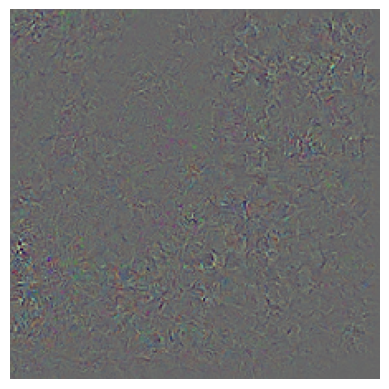

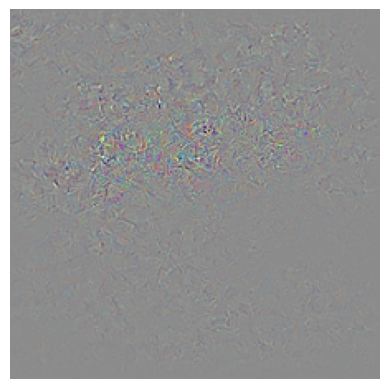

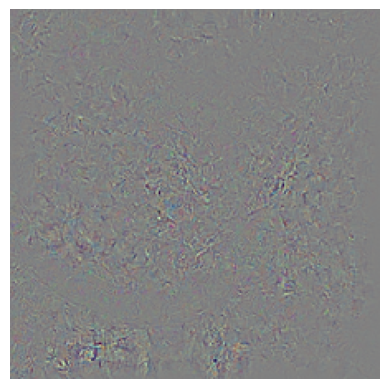

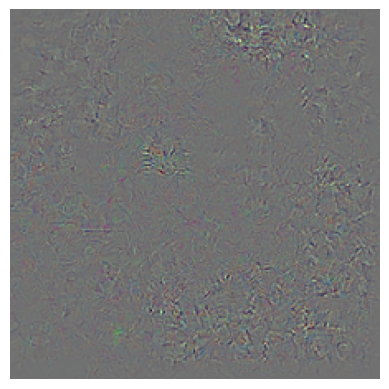

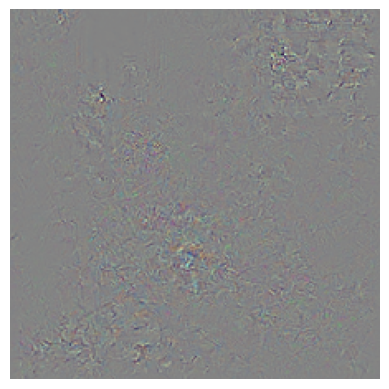

In [199]:
# Plotting the backpropagated images
for image_tensor, best_neuron in zip(images, best_neurons):
    grads = backpropagation(image_tensor, best_neuron, resnet50)
    normalized_image = norm(grads.squeeze().permute(1, 2, 0).numpy())
    plt.imshow(normalized_image)
    plt.axis('off')
    plt.show()

## b) Guided backpropagation

In [200]:
def guided_backpropagation(image, target_class, model):
    
    '''
    This function takes an image, a target class, and a model and returns the gradients of the target class with respect to the input image. It uses the guided backpropagation method.
    '''
    
    # Hook funtion to apply relu to the gradients of the input image
    def backward_hook(module, grad_in, grad_out):
        grad_in[0][grad_in[0] < 0] = 0
    
    # Hook funtion to get the gradients of the input image
    def hook_function(module, grad_in, grad_out):
        global gradient
        gradient = grad_in[0]
    
    # Register the backward hooks
    handles = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.ReLU):
            handles.append(module.register_backward_hook(backward_hook))
            
    # Register the hook to the first layer
    first_layer = list(model._modules.items())[0][1]
    handle_first = first_layer.register_full_backward_hook(hook_function)
    
    # Forward pass8
    output = model(image)
    
    # Compute gradients using backpropagation
    model.zero_grad()
    grad_output = torch.zeros_like(output)
    grad_output[0][target_class] = 1
    output.backward(grad_output)

    # Remove the hooks
    for handle in handles:
        handle.remove()
    handle_first.remove()
    
    return gradient


/Users/gunji/miniconda3/envs/torch-gpu/lib/python3.10/site-packages/torch/nn/modules/module.py:1113: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


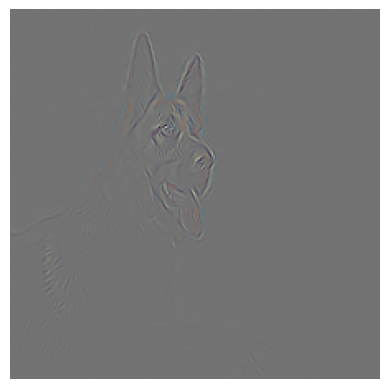

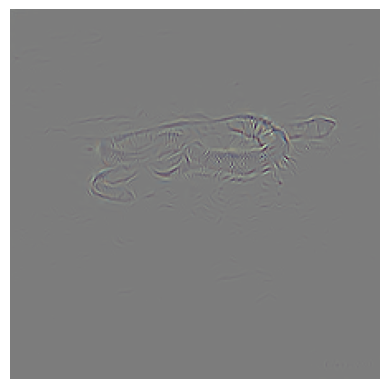

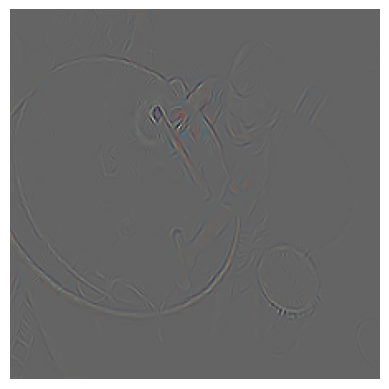

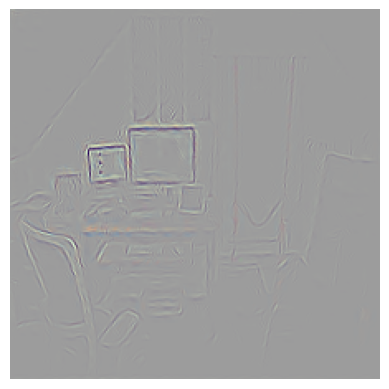

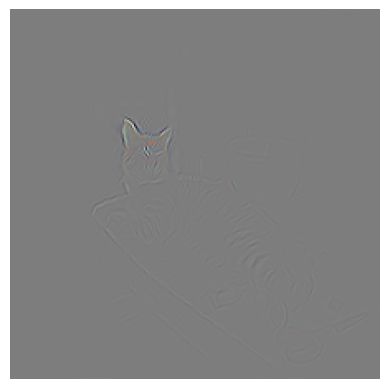

In [201]:
# PLotting the guided backpropagation images
for image_tensor, best_neuron in zip(images, best_neurons):
    guided_grads = guided_backpropagation(image_tensor, best_neuron, resnet50)
    normalized_guided_image = norm(guided_grads.squeeze().permute(1, 2, 0).numpy())
    plt.imshow(normalized_guided_image)
    plt.axis('off')
    plt.show()

## c) Class Activation Maps (CAM)

In [202]:
def cam(model, image_tensor, class_index):
    
    ''' 
    This function takes a model, an image tensor, and a class index and returns the class activation map for the class index.
    '''
    
    # Get the feature_map from the model
    features = model.conv1(image_tensor)
    features = model.bn1(features)
    features = model.relu(features)
    features = model.maxpool(features)
    features = model.layer1(features)
    features = model.layer2(features)
    features = model.layer3(features)
    feature_map = model.layer4(features).squeeze()
    
    # Get the weights for the class index from the output layer
    weights = model.fc.weight[class_index]
    weights = weights.reshape(feature_map.shape[0],1,1)
    
    # Compute the CAM by multiplying the feature map with the weights
    cam = weights * feature_map
    cam = torch.sum(cam, dim=0)
    
    # Resize the CAM to match the size of the input image
    cam = cam.reshape(1,1,7,7)
    cam = torch.nn.functional.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
    
    # Normalize the CAM between 0 and 1
    cam = torch.nn.functional.relu(cam)
    cam = norm(cam)
    
    # Convert the CAM to a numpy array
    cam = cam.squeeze().cpu().detach().numpy()
    
    # Convert the CAM to a heatmap
    heatmap = plt.imshow(cam, cmap='jet')
    plt.axis('off')
    plt.colorbar(heatmap)
    
    # Overlay the heatmap on the original image
    image = image_tensor.squeeze().permute(1, 2, 0).detach().numpy()
    plt.imshow(image, alpha=0.5) 
    plt.show()
    
    # Return the CAM
    return cam


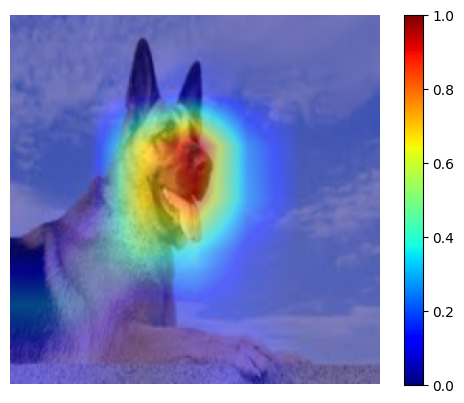

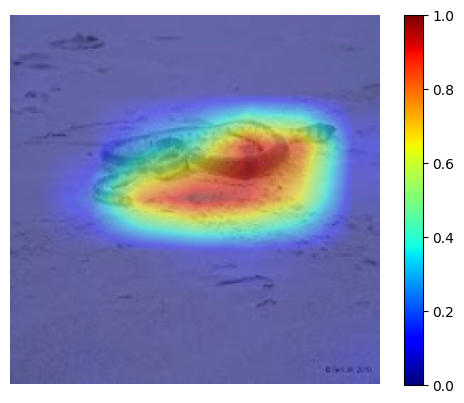

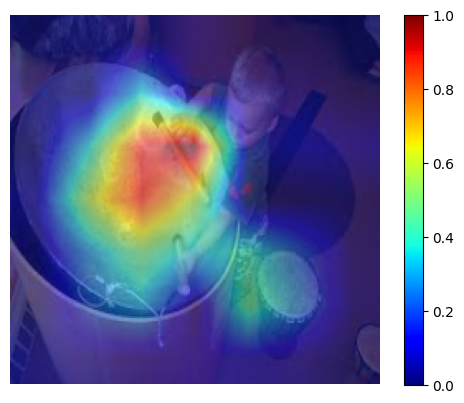

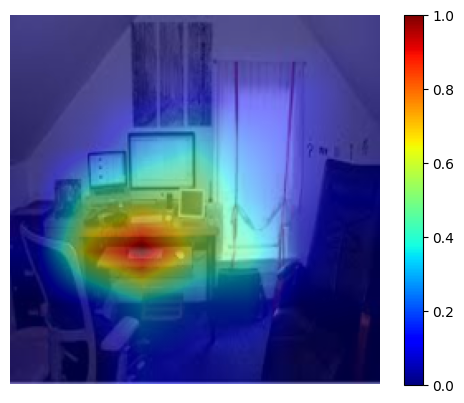

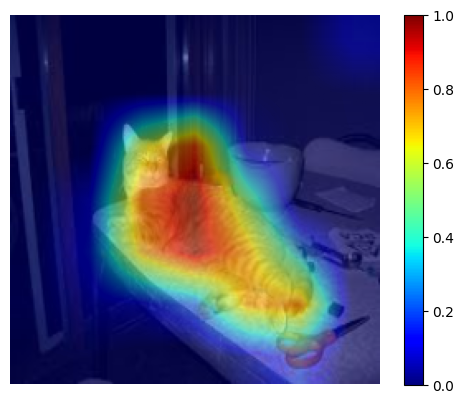

In [203]:
# Plotting the CAM for each image
for image_tensor, best_neuron in zip(images, best_neurons):
    cam_output = cam(resnet50, image_tensor, best_neuron)

## d) Guided Grad-CAM

In [204]:
def gradcam(model, image_tensor, best_neuron):
    
    ''' 
    This function takes a model, an image tensor, and a class index and returns the class activation map for the class index. It uses gradients instead of weights to compute the CAM.
    '''
    
    model.eval()
    
    # Get the feature map from the model    
    features = model.conv1(image_tensor)
    features = model.bn1(features)
    features = model.relu(features)
    features = model.maxpool(features)
    features = model.layer1(features)
    features = model.layer2(features)
    features = model.layer3(features)
    feature_map = model.layer4(features).squeeze()
    
    # Hook function to store gradients
    gradients = []
    def hook_function(module, grad_in, grad_out):
        gradients.append(grad_out[0].squeeze())
    
    # Register the hook to the last convolutional layer
    last_conv_layer = resnet50.layer4[2].relu
    handle = last_conv_layer.register_backward_hook(hook_function)
    
    # Forward pass
    output = model(image_tensor)
    
    # Compute gradients using backpropagation
    model.zero_grad()
    grad_output = torch.zeros_like(output)
    grad_output[0][best_neuron] = 1
    output.backward(grad_output)
    gradients = gradients[0]
    # Remove the hook
    handle.remove()
    
    # Reshaping the gradients to match the feature map
    gap = torch.nn.AdaptiveAvgPool2d([1,1])
    reshape_gradients = gap(gradients).squeeze()
    reshape_gradients = reshape_gradients.reshape(reshape_gradients.shape[0],1,1)
    
    # Compute the CAM by multiplying the feature map with the gradients
    grad_cam = reshape_gradients * feature_map
    grad_cam = torch.sum(grad_cam, dim=0)
    grad_cam = torch.nn.functional.relu(grad_cam)
    
    # Resize the CAM to match the size of the input image
    grad_cam = grad_cam.reshape(1,1,7,7)
    grad_cam = torch.nn.functional.interpolate(grad_cam, size=(224, 224), mode='bilinear', align_corners=False)
    
    # Normalize the CAM between 0 and 1
    grad_cam = torch.nn.functional.relu(grad_cam)
    grad_cam = grad_cam / torch.max(grad_cam)
    
    # Convert the CAM to a numpy array
    grad_cam = grad_cam.squeeze().cpu().detach().numpy()
    
    # Uncomment the following lines to plot the GradCAM
    
    # heatmap = plt.imshow(grad_cam, cmap='jet')
    # plt.axis('off')
    # plt.colorbar(heatmap)
    # image = image_tensor.squeeze().permute(1, 2, 0).detach().numpy()
    # plt.imshow(image, alpha=0.5) 
    # plt.show()
    
    # Return the CAM
    return grad_cam

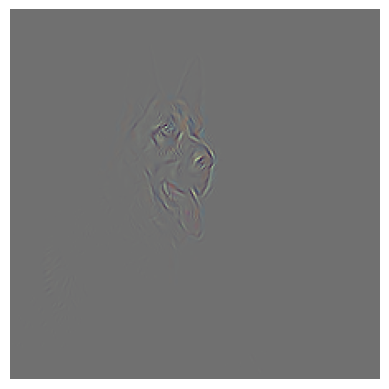

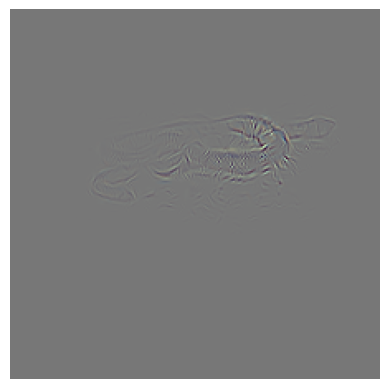

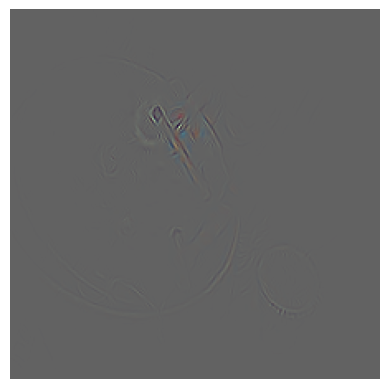

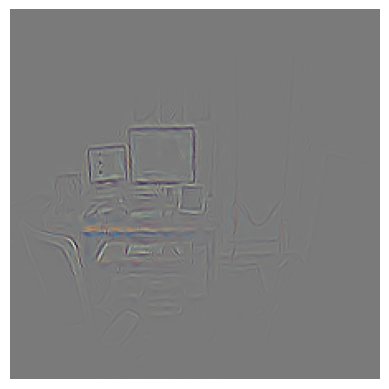

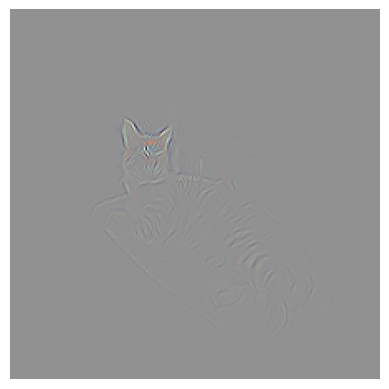

In [205]:
# Plotting the Guided GradCAM for each image
for image_tensor, best_neuron in zip(images, best_neurons):
    grad_cam_output = gradcam(resnet50, image_tensor, best_neuron)
    guided_grads = guided_backpropagation(image_tensor, best_neuron, resnet50)
    grad_cam = grad_cam_output.reshape(grad_cam_output.shape[0], grad_cam_output.shape[1], 1)
    normalized_guided_grad = (norm(grad_cam*guided_grads.squeeze().permute(1, 2, 0).numpy()))
    plt.imshow(normalized_guided_grad, cmap='jet')
    plt.axis('off')
    plt.show()

# Q2 SGD Update rule variations

In [206]:
# Define the function to be minimized
def f(x, y):
    return 10*x**2 + y**2

In [207]:
# Define the gradients of the function
def df_dx(x, y):
    return 20*x

def df_dy(x, y):
    return 2*y

In [208]:
# Define the variables
num_iterations = 50
start_point = np.array([-18, 13])

## a) Vanilla SGD

In [209]:
# Define the gradient descent function
learning_rate = 0.03
def gradient_descent(x, y, learning_rate):
    dx = df_dx(x, y)
    dy = df_dy(x, y)
    x = x - learning_rate * dx
    y = y - learning_rate * dy
    return x, y

# Get the data for the gradient descent
data_sgd = []
x,y = start_point
for i in range(num_iterations):
    x, y = gradient_descent(x, y, learning_rate)
    z = f(x, y)
    data_sgd.append([x, y, z])
data_sgd = np.array(data_sgd)

## b) SGD with momentum

In [210]:

# Define the gradient descent with momentum function
vx = 0
vy = 0
friction = 0.87
learning_rate = 0.01
def gradient_descent_momentum(x, y, learning_rate, friction):
    global vx, vy
    dx = df_dx(x, y)
    dy = df_dy(x, y)
    vx = friction * vx + dx
    vy = friction * vy + dy
    x = x - learning_rate * vx
    y = y - learning_rate * vy
    return x, y

# Get the data for the gradient descent with momentum
data_sgd_mom = []
x,y = start_point
for i in range(num_iterations):
    x, y = gradient_descent_momentum(x, y, learning_rate, friction)
    z = f(x, y)
    data_sgd_mom.append([x, y, z])
data_sgd_mom = np.array(data_sgd_mom)

## c) Nesterov Momentum

In [211]:
# Define the Nesterov momentum function
vx = 0
vy = 0
friction = 0.93
learning_rate = 0.02
def nesterov_momentum(x, y, learning_rate, friction):
    global vx, vy
    vx = friction * vx - learning_rate * df_dx(x + friction * vx, y + friction * vy)
    vy = friction * vy - learning_rate * df_dy(x + friction * vx, y + friction * vy)
    x = x + vx
    y = y + vy
    return x, y

# Get the data for the Nesterov momentum
data_nest_mom = []
x,y = start_point
for i in range(num_iterations):
    x, y = nesterov_momentum(x, y, learning_rate, friction)
    z = f(x, y)
    data_nest_mom.append([x, y, z])
data_nest_mom = np.array(data_nest_mom)

## d) AdaGrad

In [212]:
# Define the Adagrad function
gradx = 0
grady = 0
epsilon = 1e-6
learning_rate = 3.14
def adagrad(x, y, learning_rate):
    global gradx, grady
    dx = df_dx(x, y)
    dy = df_dy(x, y)
    gradx = gradx + dx**2
    grady = grady + dy**2
    x = x - (learning_rate * dx / (np.sqrt(gradx)+epsilon))
    y = y - (learning_rate * dy / (np.sqrt(grady)+epsilon))
    return x, y
 
# Get the data for the RMSProp
data_ada = []
x,y = start_point
for i in range(num_iterations):
    x, y = adagrad(x, y, learning_rate)
    z = f(x, y)
    data_ada.append([x, y, z])
data_ada = np.array(data_ada)

## e) RMSProp

In [213]:
# Define the RMSProp function
vx = 0
vy = 0
friction = 0.85
epsilon = 1e-6
learning_rate = 0.51
def RMSprop(x, y, learning_rate, friction):
    global vx, vy
    dx = df_dx(x, y)
    dy = df_dy(x, y)
    vx = friction * vx + (1 - friction) * dx**2
    vy = friction * vy + (1 - friction) * dy**2
    x = x - (learning_rate * dx / (np.sqrt(vx)+epsilon))
    y = y - (learning_rate * dy / (np.sqrt(vy)+epsilon))
    return x, y

# Get the data for the RMSProp
data_rms = []
x,y = start_point
for i in range(num_iterations):
    x, y = RMSprop(x, y, learning_rate, friction)
    z = f(x, y)
    data_rms.append([x, y, z])
data_rms = np.array(data_rms)

## Plot the results

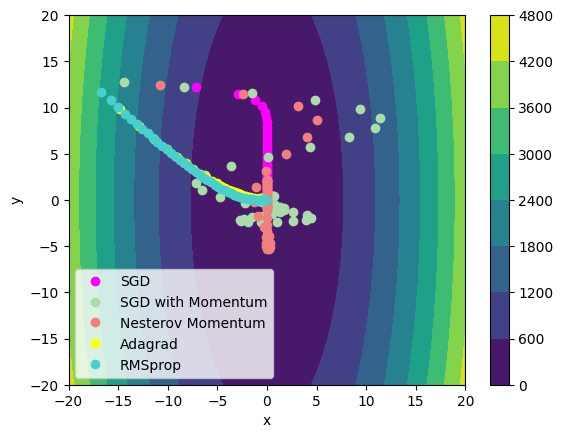

In [214]:
fig = plt.figure()
ax = plt.axes()

# Plot the function
x = np.linspace(-20, 20, 100)
y = np.linspace(-20, 20, 100)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)
func_contour = ax.contourf(X, Y, Z)
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.colorbar(func_contour, ax=ax)

# Lines for different optimizers
line_sgd, = ax.plot(data_sgd[0][0], data_sgd[0][1], c='fuchsia', label='SGD', marker='o', linestyle = 'None')
line_sgd_mom, = ax.plot(data_sgd_mom[0][0], data_sgd_mom[0][1], c='#AADDAA', label='SGD with Momentum', marker='o', linestyle = 'None')
line_nest_mom, = ax.plot(data_nest_mom[0][0], data_nest_mom[0][1], c='lightcoral', label='Nesterov Momentum', marker='o', linestyle = 'None')
line_ada, = ax.plot(data_ada[0][0], data_ada[0][1], c='yellow', label='Adagrad', marker='o', linestyle = 'None')
line_rms, = ax.plot(data_rms[0][0], data_rms[0][1], c='mediumturquoise', label='RMSprop', marker='o', linestyle = 'None')

#plot the data
lines = [line_sgd, line_sgd_mom, line_nest_mom, line_ada, line_rms]
datas = [data_sgd, data_sgd_mom, data_nest_mom, data_ada, data_rms]
def update(i):
    for data,line in zip(datas, lines):
        line.set_data(data[:i,0],data[:i,1])
    ax.legend()
ani = FuncAnimation(fig, update, num_iterations, interval=200, blit=False)
ani.save('Output.gif')
plt.show()